In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

### Reading Networks

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path']

AREA_NAME = 'NYC'
NETWORK_DIR = join(pwd, dpath, 'Nets', f'{AREA_NAME}-CBG-CBG-Nets')
nets = [(datetime.strptime(f, '%Y-%m-%d'), ig.Graph.Read_Pickle(join(NETWORK_DIR, f))) 
            for f in tqdm(os.listdir(NETWORK_DIR))]
nets = np.array(sorted(nets, key=lambda x: x[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [00:30<00:00,  3.56it/s]


### Census Attributes

In [4]:
area_cbgs = get_CBGS(join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json'), dtype=np.int64)

In [5]:
def mean_time_to_work(row, cols):
    '''
    calculates the mean travel to work time with the help of time categories
    '''
    duration = 0
    w = 0
    for col in cols:
        seg = col.split('-')
        minutes = (int(seg[1]) + int(seg[-1])) / 2
        duration += row[col]*minutes
        w += row[col]
    return duration/w

In [6]:
def get_census_attrs(rank_list=[]):
    '''
    reads and prepares the census attributes
    `rank_list` stores the attributes to be worked as ranked values
    '''
    census_attrs = pd.read_csv(join(pwd, 'util_datasets', 'census_attributes.csv'))
    census_attrs = census_attrs[census_attrs['census_block_group'].isin(area_cbgs)]

    commuting_cols = [i for i in census_attrs.columns if i.startswith('t-')]
    census_attrs['mean_time_to_work'] = census_attrs.apply(mean_time_to_work, cols=commuting_cols, axis=1)

    edu_cols = [i for i in census_attrs.columns if 'edu-' in i]
    census_attrs['education'] = sum([census_attrs[i] for i in edu_cols])

    census_attrs['racial_diversity'] = census_attrs.apply(lambda row: entropy([row['white_population'], row['black_population'], row['asian_population'], row['hispanic_population']]), axis=1)
    census_attrs = census_attrs.rename(columns={'median_house_income': 'income'})

    col_names = ['income', 'white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
    quart = ['Bottom', 'Third', 'Second', 'Top']
    for col in col_names:
        census_attrs[f'{col}-quartile'] = pd.qcut(census_attrs[col], q=4, labels=[f'{quart[i]}' for i in range(4)])

    census_quartiles = census_attrs[['census_block_group', *[f'{cn}-quartile' for cn in col_names]]]
    census_raw_values = census_attrs[['census_block_group', *col_names]]
    
    for attr in rank_list:
        census_raw_values[attr] = census_raw_values[attr].rank(pct=True)
    
    return census_quartiles, census_raw_values

In [7]:
zcta_df = pd.read_csv(join(pwd, 'util_datasets', 'bg-zip-pop2.csv'))
zcta_df['BG GEO-ID'] = zcta_df['BG GEO-ID'].str[1:]
zcta_df['BG GEO-ID'] = zcta_df['BG GEO-ID'].astype(np.int64)
zcta_df = zcta_df[zcta_df['BG GEO-ID'].isin(set(area_cbgs))]
zcta_df['cbg_ratio'] = zcta_df['BG Population Part in Zip'] / zcta_df['Zip Population']
zcta_df = zcta_df.set_index('BG GEO-ID')

In [8]:
case_df = pd.read_csv(join(pwd, 'util_datasets', 'nyc-daily-cases.csv'))
weeks = np.sort(pd.to_datetime(case_df.Date).unique())

In [9]:
rows = []
for cbg in tqdm(zcta_df.index.unique()):
    zip_codes = zcta_df.loc[[cbg]][['ZipCode', 'cbg_ratio']]
    filtered_df = case_df[case_df.ID.isin(zip_codes['ZipCode'].values)]
    r = pd.merge(zip_codes, filtered_df, left_on='ZipCode', right_on='ID')
    r['Norm_Cases'] = r['Cases_New'] * r['cbg_ratio']
    r = r.groupby('Date')[['Norm_Cases']].sum().reset_index()
    r['cbg'] = cbg
    rows.append(r)

100%|█████████████████████████████████████████████████████████████████████████████| 6252/6252 [00:35<00:00, 176.75it/s]


In [10]:
cases_df = pd.concat(rows, axis=0)

### Demographic Groups vs Cases

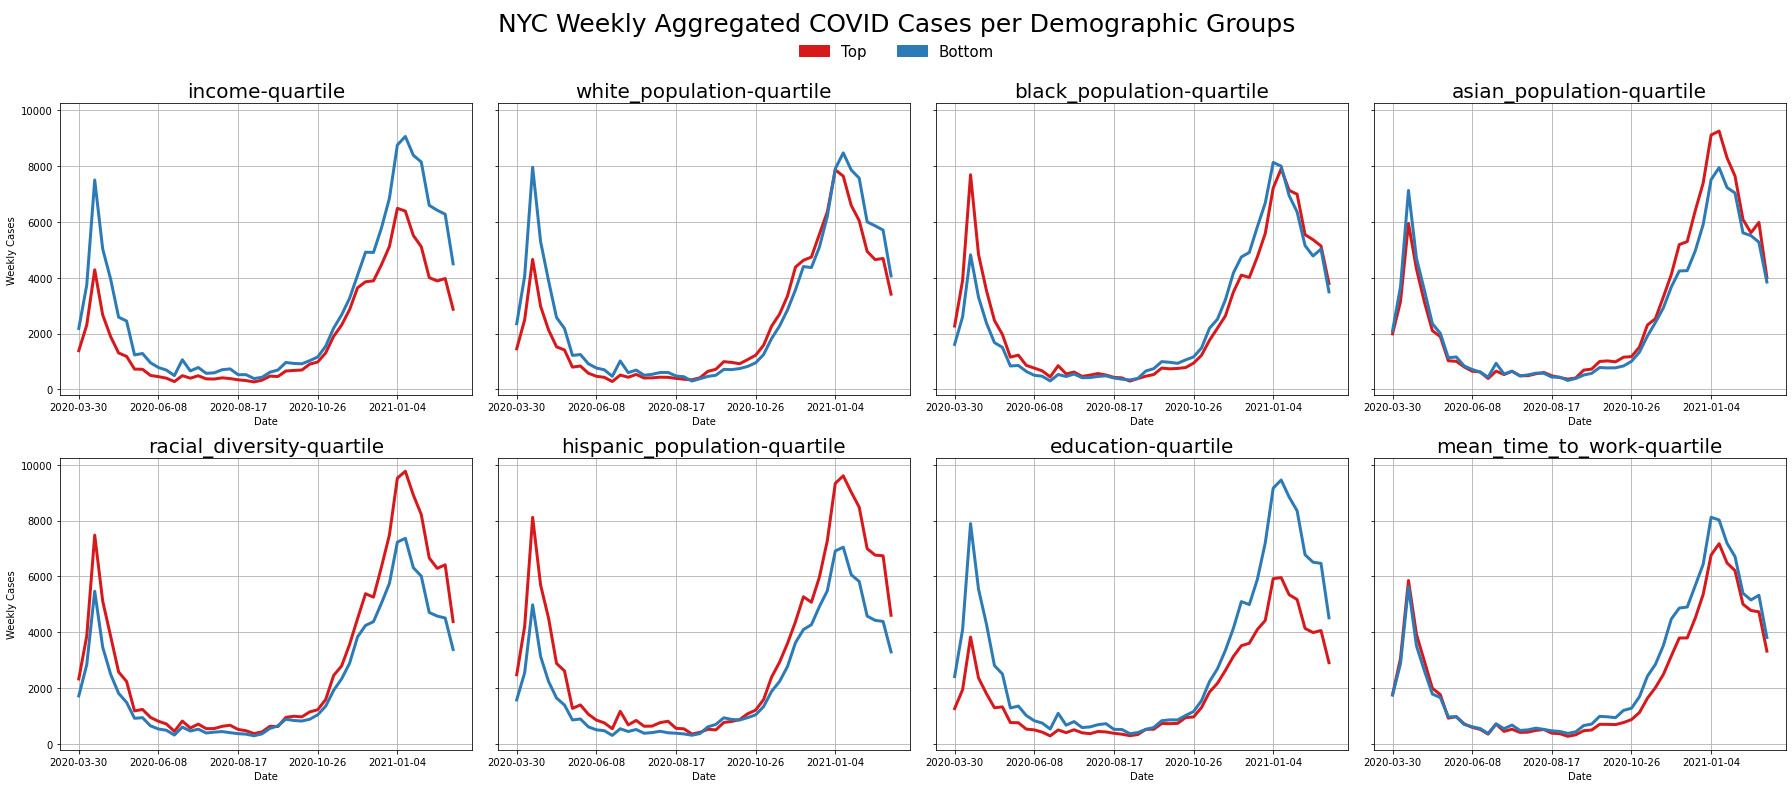

In [11]:
census_quartiles, _ = get_census_attrs()
cols = [col for col in census_quartiles.columns if 'quartile' in col]
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(25, 10))

topc = '#d7191c'
bottomc = '#2c7bb6'

for ax, col in zip(axes.flatten(), cols):
    top_cbg = census_quartiles[census_quartiles[col] == 'Top']
    bottom_cbg = census_quartiles[census_quartiles[col] == 'Bottom']
    
    cases_df[cases_df['cbg'].isin(top_cbg['census_block_group'].values)].groupby('Date').sum()['Norm_Cases'].plot(ax=ax, color=topc, linewidth=3)
    cases_df[cases_df['cbg'].isin(bottom_cbg['census_block_group'].values)].groupby('Date').sum()['Norm_Cases'].plot(ax=ax, color=bottomc, linewidth=3)
    ax.set_title(col, fontsize=20)
    ax.set_ylabel('Weekly Cases')
    ax.grid()
    
top_patch = mpatches.Patch(color=topc)
bottom_patch = mpatches.Patch(color=bottomc)

fig.legend([top_patch, bottom_patch],
                   ['Top', 
                    'Bottom'],
                   loc="center",
                   ncol=2,
                   bbox_to_anchor=(0.5, 1.05), 
                   fontsize=15,
                   title_fontsize=25,
                   title="NYC Weekly Aggregated COVID Cases per Demographic Groups", 
                   edgecolor="white")

fig.tight_layout()
fig.savefig(join(FIG_SAVE_DIR, "nyc-covid-cases-per-demographics-quartiles.png"), bbox_inches="tight")

### Income vs Racial Groups

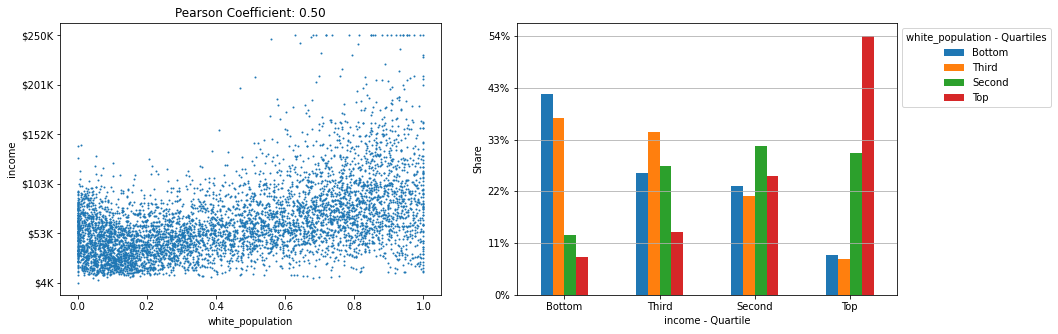

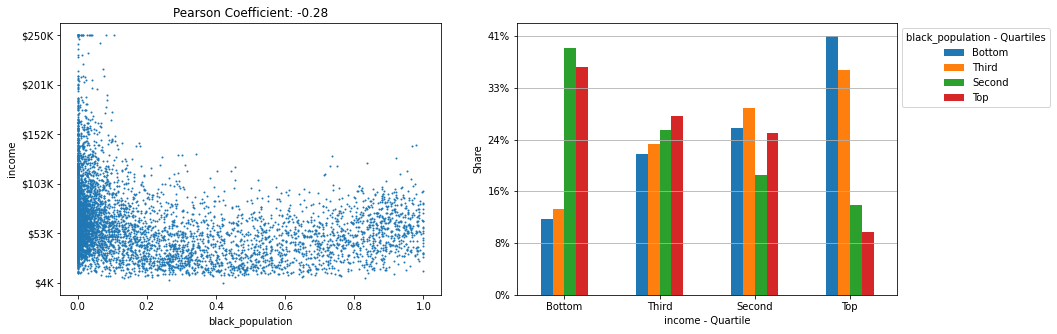

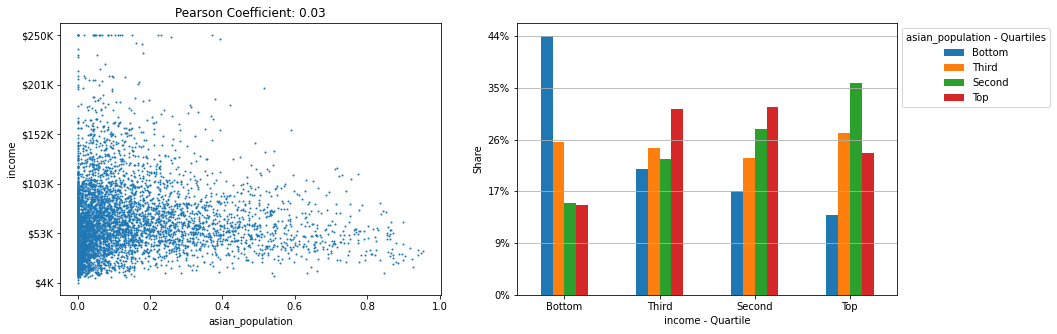

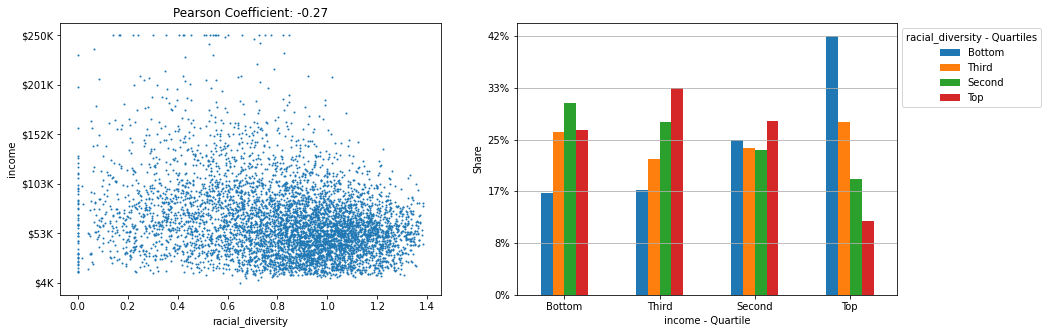

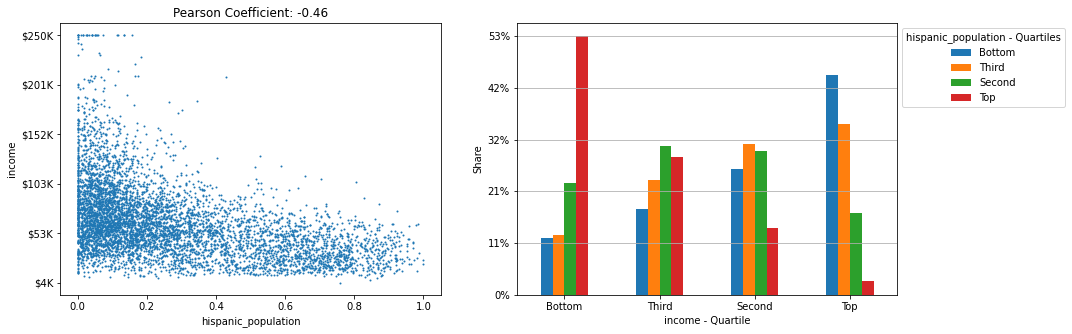

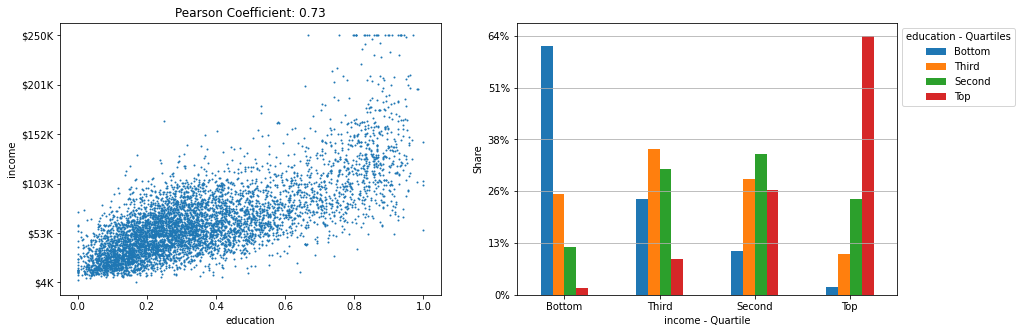

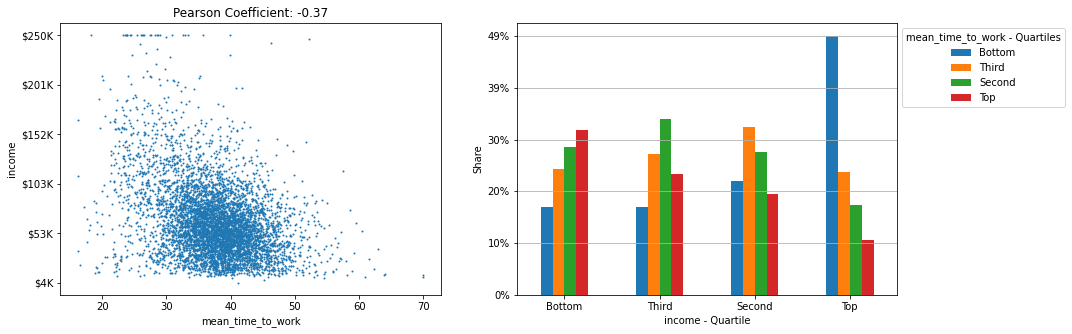

In [14]:
census_quartiles, census_raw_values = get_census_attrs()
groups = ['white_population', 'black_population', 'asian_population', 'racial_diversity', 'hispanic_population', 'education', 'mean_time_to_work']
for sattr in groups:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].scatter(census_raw_values[sattr], census_raw_values['income'], s=1)
    axes[0].set_xlabel(sattr)
    axes[0].set_ylabel('income')
    coeff = census_raw_values[[sattr, 'income']].corr(method='pearson').values[1,0]
    axes[0].set_title(f'Pearson Coefficient: {coeff:.2f}')

    xr = np.linspace(census_raw_values['income'].min(), census_raw_values['income'].max(), 6)
    lbl = [f'${x / 1000:.0f}K' for x in xr]
    axes[0].set_yticks(xr)
    axes[0].set_yticklabels(lbl)

    tb = pd.crosstab(census_quartiles['income-quartile'], census_quartiles[f'{sattr}-quartile'], normalize='index')
    stats.chi2_contingency(tb)
    tb.plot.bar(ax=axes[1], rot=0)
    axes[1].grid(axis='y')
    axes[1].legend(title=f'{sattr} - Quartiles', bbox_to_anchor=(1,1))
    axes[1].set_xlabel('income - Quartile')
    axes[1].set_ylabel('Share')

    yr = np.linspace(0, tb.values.max(), 6)
    lbl = [f'{y*100:.0f}%' for y in yr]
    axes[1].set_yticks(yr)
    axes[1].set_yticklabels(lbl);

    fig.savefig(join(FIG_SAVE_DIR, f'{sattr}-income-corr.png'), bbox_inches='tight');

### Network Summaries

In [339]:
n_edges = []
mean_in_deg = []
mean_out_deg = []
mean_total_deg = []
mean_wdeg = []
diameter = []
clustering_coef = []
mean_path_len = []
density = []
local_clustering = []
for net in tqdm(nets):
    n_edges.append(len(net[1].es))
    mean_in_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='in')))
    mean_out_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='out')))
    mean_total_deg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')))
    mean_wdeg.append(np.nanmean(ig.Graph.degree(net[1], mode='all')) / len(net[1].vs))
    diameter.append(ig.Graph.diameter(net[1], directed=True, unconn=net[1].is_connected()))
    density.append(ig.Graph.density(net[1], loops=True))
    clustering_coef.append(ig.Graph.transitivity_undirected(net[1]))
    mean_path_len.append(ig.Graph.average_path_length(net[1], directed=True, unconn=net[1].is_connected()))
    local_clustering.append(np.nanmean(ig.Graph.transitivity_local_undirected(net[1], weights='weight')))

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [06:00<00:00,  3.37s/it]


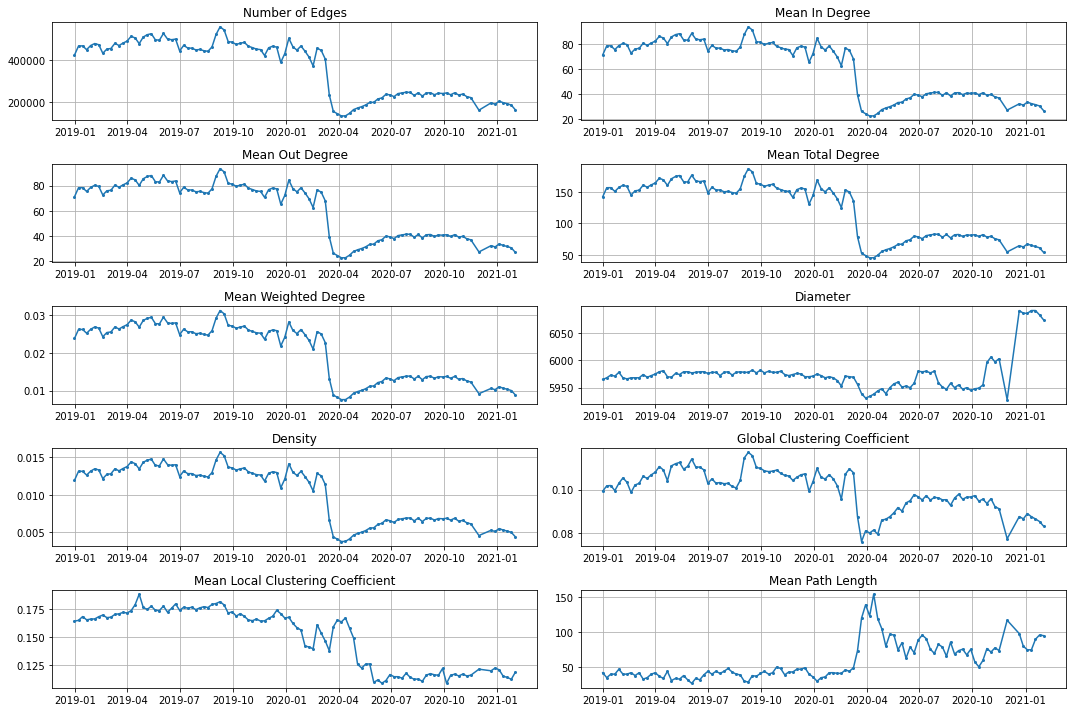

In [350]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

arrays = [
    (n_edges, 'Number of Edges'),
    (mean_in_deg, 'Mean In Degree'),
    (mean_out_deg, 'Mean Out Degree'),
    (mean_total_deg, 'Mean Total Degree'),
    (mean_wdeg, 'Mean Weighted Degree'),
    (diameter, 'Diameter'),
    (density, 'Density'),
    (clustering_coef, 'Global Clustering Coefficient'),
    (local_clustering, 'Mean Local Clustering Coefficient'),
    (mean_path_len, 'Mean Path Length'),
]

# time steps
dx = [net[0] for net in nets]

for i, ax in enumerate(axes.flatten()):
    ax.plot(dx, arrays[i][0], marker='o', markersize=2)
    ax.set_title(arrays[i][1])
    ax.grid()
    
plt.tight_layout()
plt.savefig(join(FIG_SAVE_DIR, f'{AREA_NAME}-net-summary.png'), bbox_to_inches='tight')

### Temporal Change in Centrality Metrics by Demographic Groups 

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [12]:
def change_sign(val):
    '''
    returns the sign of the change
    '''
    if np.abs(val) <= 0.5:
        return 'neutral'
    elif val > 0:
        return 'positive'
    else:
        return 'negative'

In [13]:
def get_metric_change_df(t1, t2, attribute_df):
    '''
    calculates the centrality metrics and assings the values to the CBGs
    at the end, merges with the provided attribute df
    '''
    cent_metrics = [
        ('Closeness', ig.Graph.closeness, {'cutoff': -1, 'normalized': True}), 
        ('Betweenness', ig.Graph.betweenness, {'cutoff': -1, 'directed': True}), 
        ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True})
    ]

    ts_source = datetime.strptime(t1, '%Y-%m-%d')
    ts_target = datetime.strptime(t2, '%Y-%m-%d')

    net_source = nets[nets[:, 0] == ts_source][0,1]
    net_target = nets[nets[:, 0] == ts_target][0,1]
    
    dfs = []
    for cent_metric_name, cent_metric, params in cent_metrics:
        source_vals = np.array(cent_metric(net_source, **params))
        target_vals = np.array(cent_metric(net_target, **params))

        source_data = {
            'source_value': source_vals,
            'CBG': net_source.vs['name']
        }

        target_data = {
            'target_value': target_vals,
            'CBG': net_target.vs['name']
        }

        source_df = pd.DataFrame(source_data)
        target_df = pd.DataFrame(target_data)

        r = pd.merge(source_df, target_df, on="CBG", how='inner')
        r[f'{cent_metric_name}_relative_change'] = (r['target_value'] - r['source_value']) / r['source_value'] * 100
        r[f'{cent_metric_name}_change_sign'] = r[f'{cent_metric_name}_relative_change'].apply(change_sign)
        r['CBG'] = r['CBG'].astype(np.int64)
        d = pd.merge(attribute_df, r, left_on='census_block_group', right_on='CBG', how='inner')
        dfs.append((cent_metric_name, d))
        
    return dfs

### Centrality Metrics vs COVID Cases 

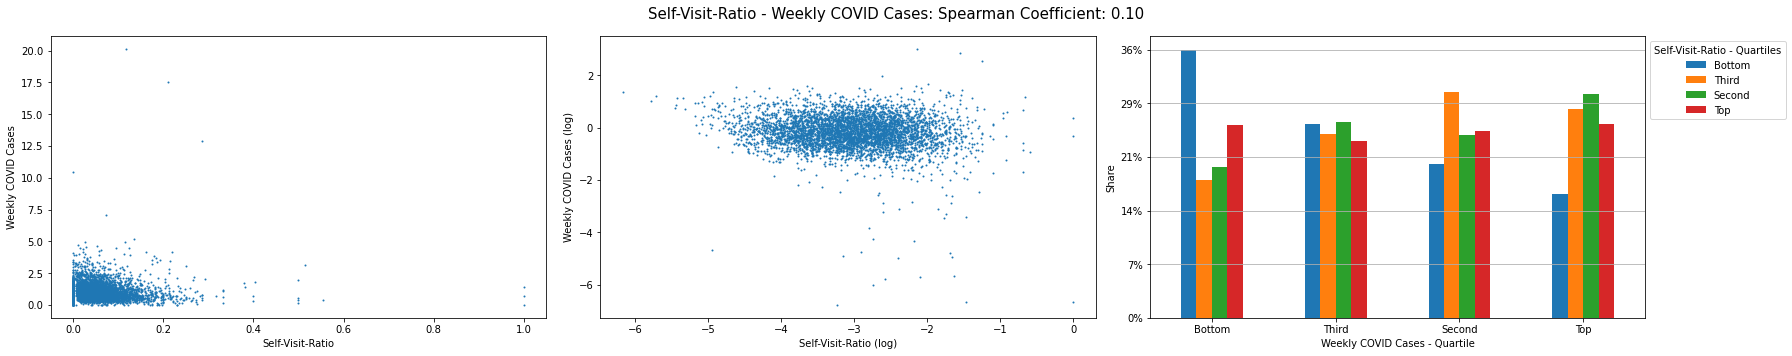

In [29]:
tmetric = datetime(2020, 10, 19)
tcase = tmetric + timedelta(days=7*2)

tnet = nets[nets[:, 0] == tmetric][0,1]
tcbgs = cases_df[cases_df.Date == tcase.strftime('%Y-%m-%d')]

quart = ['Bottom', 'Third', 'Second', 'Top']
tcbgs['cases-quartile'] = pd.qcut(tcbgs['Norm_Cases'], q=4, labels=quart)

cent_metrics = [
    #('Closeness', ig.Graph.closeness, {'cutoff': -1, 'normalized': True}), 
    #('Betweenness', ig.Graph.betweenness, {'cutoff': -1, 'directed': True}), 
    #('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    #('In-Degree', 'in', None),
    #('Out-Degree', 'out', None),
    #('Total-Degree', 'all', None),
    ('Self-Visit-Ratio', 'self', None)
]

results = []
results_norm = []
for cent_metric_name, metric, params in cent_metrics:
    if not isinstance(metric, str) and params:
        values = np.array(metric(tnet, **params))
    elif isinstance(metric, str) and not params:
        if metric != 'self':
            #values = tnet.degree(mode=metric, loops=False)
            values = tnet.strength(loops=False, mode=metric, weights='visits')
        else:
            self_visits = np.subtract(tnet.strength(loops=True, mode='in', weights='visits'), tnet.strength(mode='in', loops=False, weights='visits'))
            out_visits = np.array(tnet.strength(loops=False, mode='out', weights='visits'))
            total_visits = self_visits + out_visits + 0.001

            values = self_visits/total_visits
    else:
        nodes = tnet.vs['name']
        values = []
        for node in nodes:
            v = 0
            if 'In' in cent_metric_name:
                v += sum([i['visits'] for i in tnet.es.select(lambda edge: edge.target_vertex['name'] == node)])
            else:
                v += sum([i['visits'] for i in tnet.es.select(lambda edge: edge.source_vertex['name'] == node)])
            values.append(v)
    data = {
        'value': values,
        'cbg': tnet.vs['name']
    }
    net_df = pd.DataFrame(data)
    net_df['cbg'] = net_df['cbg'].astype(np.int64)
    net_df['value-quartile'] = pd.qcut(net_df['value'], q=4, labels=quart)
    
    merged_df = pd.merge(tcbgs, net_df, on='cbg', how='inner')
    
    fig, axes = plt.subplots(1, 3, figsize=(25, 5))
    
    axes[0].scatter(merged_df['value'], merged_df['Norm_Cases'], s=1)
    axes[0].set_ylabel('Weekly COVID Cases')
    axes[0].set_xlabel(f'{cent_metric_name}')

    axes[1].scatter(np.log(merged_df['value']), np.log(merged_df['Norm_Cases']), s=1)
    axes[1].set_ylabel('Weekly COVID Cases (log)')
    axes[1].set_xlabel(f'{cent_metric_name} (log)')
    coeff = merged_df[['Norm_Cases', 'value']].corr(method='spearman').values[1,0]

    tb = pd.crosstab(merged_df['cases-quartile'], merged_df['value-quartile'], normalize='index')
    tb.plot.bar(ax=axes[2], rot=0)
    axes[2].grid(axis='y')
    axes[2].legend(title=f'{cent_metric_name} - Quartiles', bbox_to_anchor=(1,1))
    axes[2].set_xlabel('Weekly COVID Cases - Quartile')
    axes[2].set_ylabel('Share')

    yr = np.linspace(0, tb.values.max(), 6)
    lbl = [f'{y*100:.0f}%' for y in yr]
    axes[2].set_yticks(yr)
    axes[2].set_yticklabels(lbl);

    fig.suptitle(f'{cent_metric_name} - Weekly COVID Cases: Spearman Coefficient: {coeff:.2f}', fontsize=15)
    plt.tight_layout()
    
    Y_norm = pd.Series(stats.zscore(merged_df['Norm_Cases'].values), name='Norm_Cases')
    X_norm = pd.DataFrame(stats.zscore(merged_df[['value']].values))
    X_norm.columns = ['value']
    
    res = sm.OLS(merged_df['Norm_Cases'], add_constant(merged_df[['value']])).fit() 
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results.append(r)
    
    res = sm.OLS(Y_norm, add_constant(X_norm)).fit()
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results_norm.append(r)
    
    fig.savefig(join(FIG_SAVE_DIR, f'{cent_metric_name}-weekly-covid-cases-corr-{tmetric.strftime("%Y-%m-%d")}-no-loops-visits-self_visit_ratio.png'), bbox_inches='tight');
    
title = 'weekly-covid-cases-reg-centr-metrics-no-loops-visits-self_visit_ratio'
groups = [
    (results, f'{title}.tex'),
    (results_norm, f'{title}-norm.tex')
]
for res, fname in groups:
    with pd.option_context('display.float_format', '{:.3f}'.format):
        with open(join(RESULT_SAVE_DIR, fname), 'w') as tablef:
            tablef.write(pd.concat(res).groupby(['Centrality Metric', 'R2-Adj', 'Attribute']).sum().to_latex(bold_rows=True, multirow=True))

### Regression Model btw Relative Centrality Changes & Demographical Attributes 

#### Between Two Dates

In [23]:
t1 = '2020-01-13'
t2 = '2020-06-08'
dfs = get_metric_change_df(t1, t2, census_attrs_features)

In [24]:
features = ['income', 'white_population', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

for metric_name, df in dfs:
    df = df.dropna()
    
    res = sm.OLS(df[f'{metric_name}_relative_change'], df[features]).fit()
    with open(join(RESULT_SAVE_DIR, f'{metric_name}-{t1}-{t2}-ols-results-income-excluded.txt'), 'w') as f:
        f.write(res.summary().as_text())

#### Average of Jan-Feb-March & Apr-May-Jun

In [18]:
census_quartiles, census_raw_values = get_census_attrs(rank_list=['income'])

In [19]:
# Jan-Feb-March & Apr-May-Jun networks
grouped_nets = nets[(nets[:, 0] >= datetime(2020, 1, 1)) & (nets[:, 0] < datetime(2020, 7, 1))]
# first case
mid = np.where(grouped_nets[:, 0] == datetime(2020, 3, 9))[0][0]

# find the cbgs that exists in all networks
cbgs = []
for ind in range(len(grouped_nets)):
    cbgs.append(grouped_nets[ind, 1].vs['name'])
    
cbgs = reduce(np.intersect1d, cbgs)
cbg_attrs = census_raw_values.set_index('census_block_group').loc[cbgs.astype(np.int64)].dropna()
cbgs = cbg_attrs.index.values.astype(str)

### VIF

In [37]:
features = ['income', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']
norm = census_attrs_features[features].dropna()
norm = pd.DataFrame(stats.zscore(norm.values))
norm.columns = features

vif_data = pd.DataFrame() 
vif_data["feature"] = norm.columns
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(norm.values, i) 
                          for i in range(len(norm.columns))] 
vif_data.to_csv(join(RESULT_SAVE_DIR, 'vif-white-removed-norm.csv'), index=False)
vif_data

,feature,VIF
0,income,2.268127
1,black_population,1.882548
2,asian_population,1.457281
3,hispanic_population,1.855393
4,education,2.795531
5,mean_time_to_work,1.289685


In [20]:
features = ['income', 'black_population', 'asian_population', 'hispanic_population', 'education', 'mean_time_to_work']

cent_metrics = [
    ('Closeness', ig.Graph.closeness, {'cutoff': 3, 'normalized': True}), 
    ('Betweenness', ig.Graph.betweenness, {'cutoff': 3, 'directed': True}), 
    ('Eigenvector', ig.Graph.eigenvector_centrality, {'directed': True, 'scale': True}),
    ('In-Degree', 'in', None),
    ('Out-Degree', 'out', None),
    ('Total-Degree', 'all', None)
]

title = 'white-removed-ranked-income-no-loops-visits'
results = []
results_norm = []
for cent_metric_name, metric, params in cent_metrics:
    net_dfs = []
    for timestamp, net in tqdm(grouped_nets):
        if not isinstance(metric, str) and params:
            values = np.array(metric(net, **params))
        elif isinstance(metric, str) and not params:
            #values = net.degree(mode=metric, loops=False)
            values = net.strength(loops=False, mode=metric, weights='visits')
        else:
            nodes = net.vs['name']
            values = []
            for node in nodes:
                v = 0
                if 'In' in cent_metric_name:
                    v += sum([i['visits'] for i in net.es.select(lambda edge: edge.target_vertex['name'] == node)])
                else:
                    v += sum([i['visits'] for i in net.es.select(lambda edge: edge.source_vertex['name'] == node)])
                values.append(v)
        data = {
            'value': values,
            'CBG': net.vs['name']
        }
        net_df = pd.DataFrame(data).set_index('CBG')
        net_dfs.append(net_df.loc[cbgs, 'value'].values)

    net_dfs = np.array(net_dfs)
    # Jan-Feb-March
    g1 = net_dfs[:mid]
    mean_vals_g1 = g1.mean(axis=0)
    # Apr-May-Jun
    g2 = net_dfs[mid:]
    mean_vals_g2 = g2.mean(axis=0)

    # compute relative change
    rel_chg = (mean_vals_g2 - mean_vals_g1) / mean_vals_g1 * 100

    res = sm.OLS(pd.Series(rel_chg, name=f'{cent_metric_name} Relative Change, Jan-Feb-March vs Apr-May-Jun', index=cbg_attrs.index), add_constant(cbg_attrs[features])).fit()
    
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results.append(r)
    
    with open(join(RESULT_SAVE_DIR, f'{cent_metric_name}-ols-results-three-months-{title}.txt'), 'w') as f:
        f.write(res.summary().as_text())
        
    X_norm = pd.DataFrame(stats.zscore(cbg_attrs[features].values), index=cbg_attrs.index)
    X_norm.columns = features
    
    res = sm.OLS(pd.Series(stats.zscore(rel_chg), name=f'{cent_metric_name} Relative Change, Jan-Feb-March vs Apr-May-Jun', index=cbg_attrs.index), 
                 add_constant(X_norm)).fit()
    
    r = pd.concat([res.params, res.pvalues, res.bse], axis=1).reset_index()
    r.columns = ['Attribute', 'Coef', 'P-Value', 'Std Err']
    r['Centrality Metric'] = cent_metric_name
    r['R2-Adj'] = res.rsquared_adj
    results_norm.append(r)
        
    with open(join(RESULT_SAVE_DIR, f'{cent_metric_name}-ols-results-three-months-{title}-norm.txt'), 'w') as f:
        f.write(res.summary().as_text())
    
title = 'white-removed-ranked-income-no-loops-visits'
groups = [
    (results, f'{title}.tex'),
    (results_norm, f'{title}-norm.tex')
]
for res, fname in groups:
    with pd.option_context('display.float_format', '{:.3f}'.format):
        with open(join(RESULT_SAVE_DIR, fname), 'w') as tablef:
            tablef.write(pd.concat(res).groupby(['Centrality Metric', 'R2-Adj', 'Attribute']).sum().to_latex(bold_rows=True, multirow=True))

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 59.66it/s]


### Centrality Metric Changes per Demographic Groups

In [29]:
def plot_change_in_metrics_by_demo_groups(df, metric_name, mode, t1, t2, normalize='index'):
    '''
    plots the centrality metric changes with two options:
        - quartile frequencies
        - mean relative change
        
    normalizes by quartiles (columns) or change in metrics (index)
    '''
    top_color = "#d7191c"
    neutral_color = '#fdb863'
    bottom_color = "#2c7bb6"

    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    cols = [col for col in cattr.columns if '-quartile' in col]
    for ind, attr in enumerate(cols):

        ax = axes[ind]

        pd.crosstab(df[attr], df[f'{metric_name}_{mode}'], normalize=normalize).plot.barh(ax=ax, )

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Demographic Group')
        ax.set_title(f"{attr.split('-')[0]}")

    xlocs = np.linspace(0, 1, 5)
    lbl = [f"{loc*100:.0f}%" for loc in xlocs]

    for ax in axes:
        ax.set_xticks(xlocs)
        ax.set_xticklabels(lbl)
        ax.grid(axis='x', color='white')

    top_patch = mpatches.Patch(color='white')
    neutral_patch = mpatches.Patch(color='white')
    bottom_patch = mpatches.Patch(color='white')
    
    fig.legend([top_patch, neutral_patch, bottom_patch],
                       [f'Positive ({df[df[f"{metric_name}_{mode}"] == "positive"].shape[0]} CBGs)', 
                        f'Neutral ({df[df[f"{metric_name}_{mode}"] == "neutral"].shape[0]} CBGs)', 
                        f'Negative ({df[df[f"{metric_name}_{mode}"] == "negative"].shape[0]} CBGs)'],
                       loc="center",
                       ncol=3,
                       bbox_to_anchor=(0.5, 1.05), 
                       title_fontsize=15,
                       title=f"{metric_name} Centrality Change in Quartiles per Demographic Groups, {t1}/{t2}", 
                       edgecolor="white")

    plt.tight_layout()
    fig.savefig(join(FIG_SAVE_DIR, f"{metric_name}-{mode}-{normalize}-{t1}-{t2}.png"), bbox_inches="tight")

In [30]:
t1 = '2020-01-13'
t2 = '2020-05-11'
qdfs = get_metric_change_df(t1, t2, cattr)

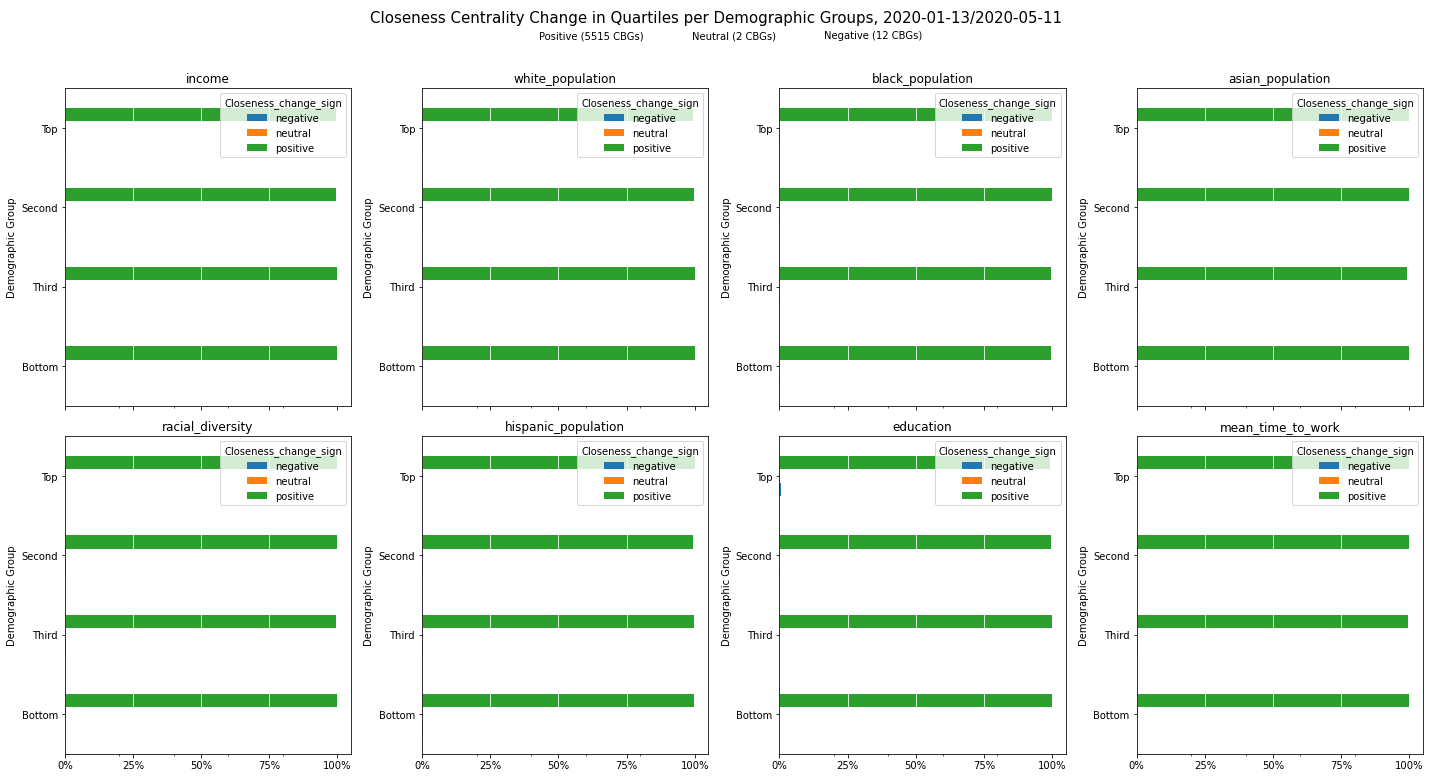

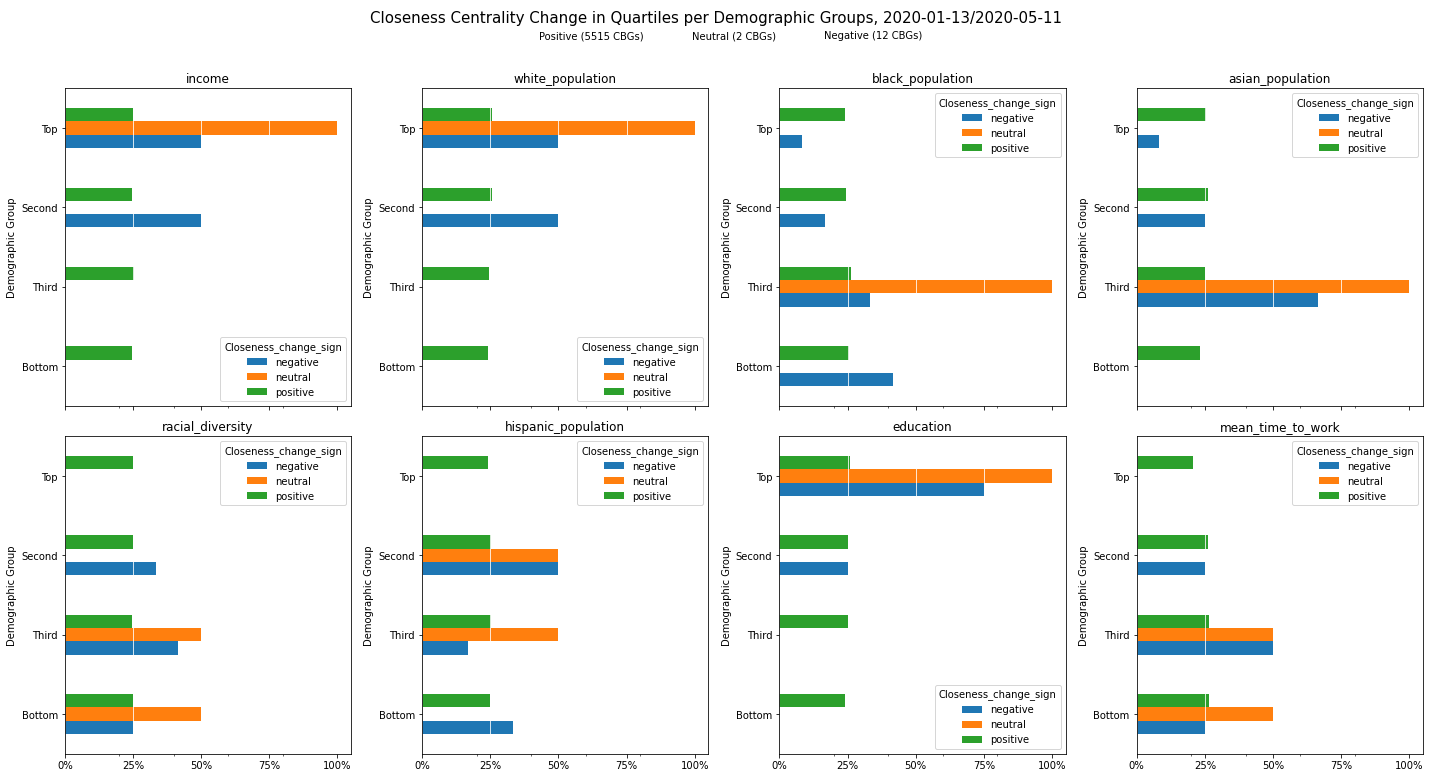

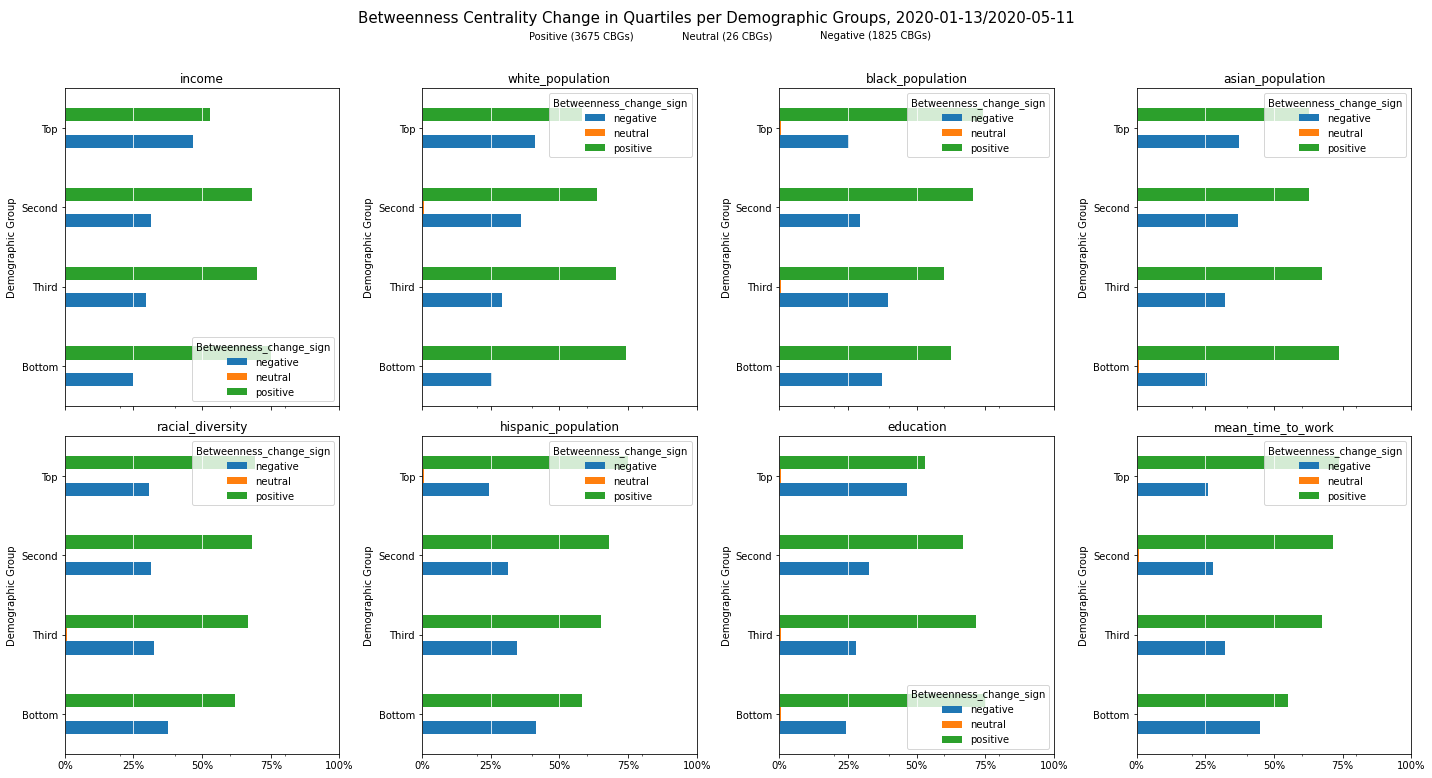

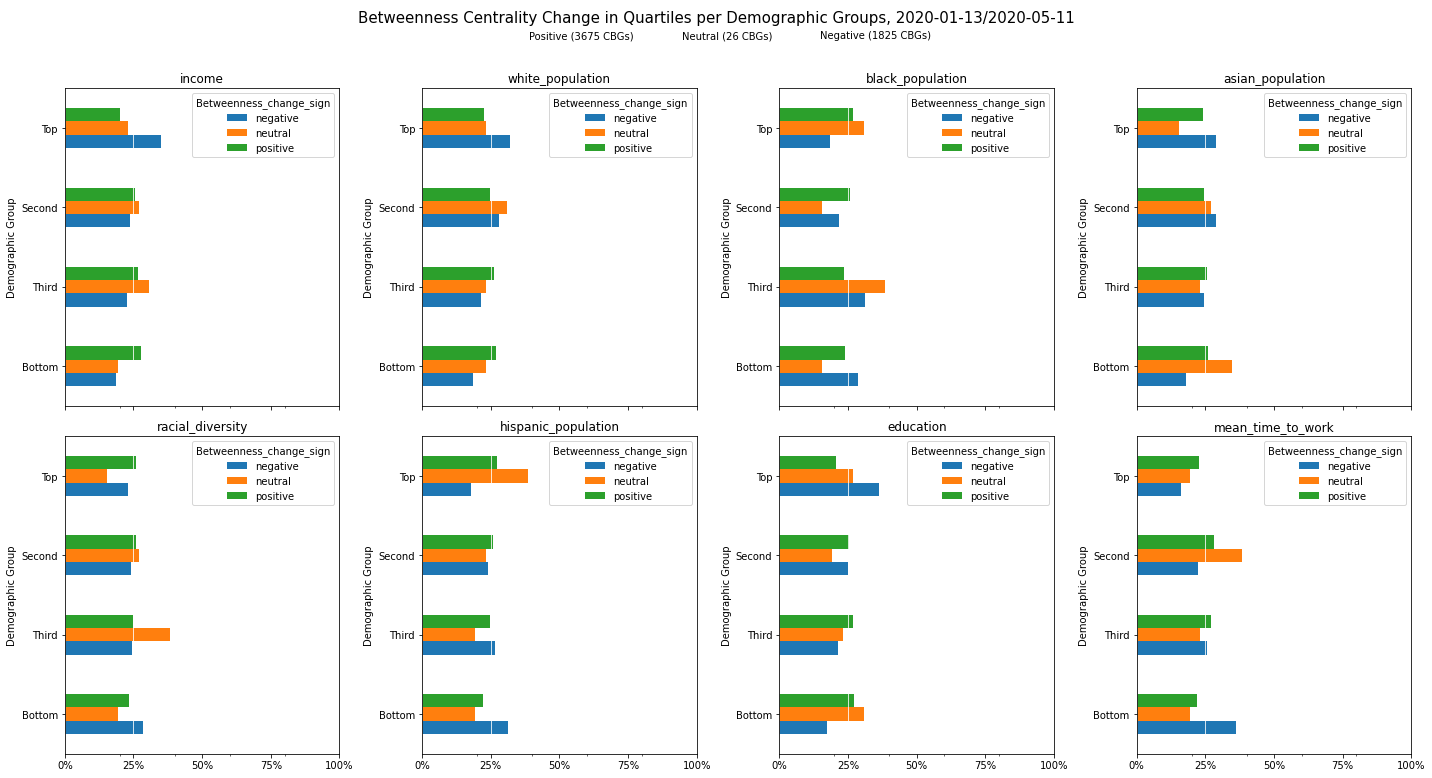

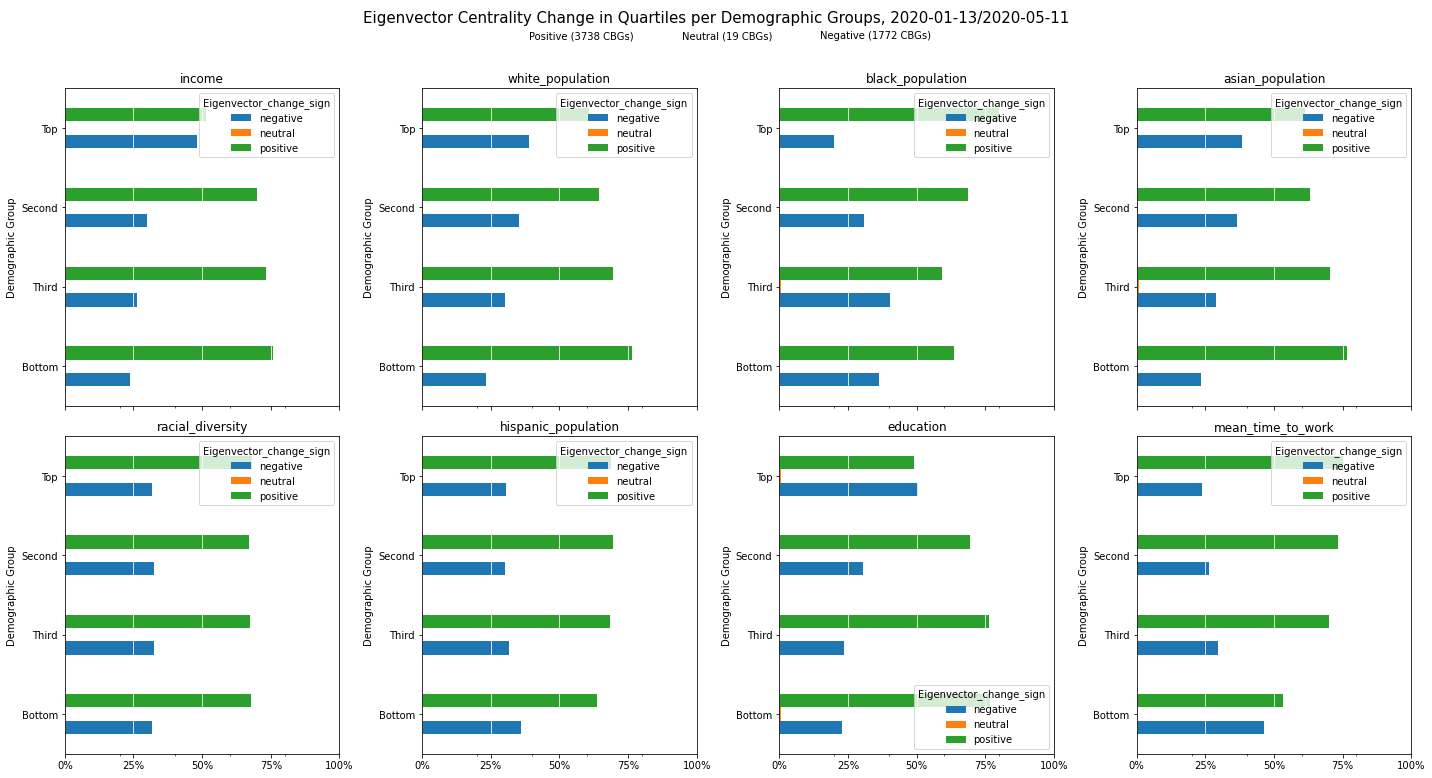

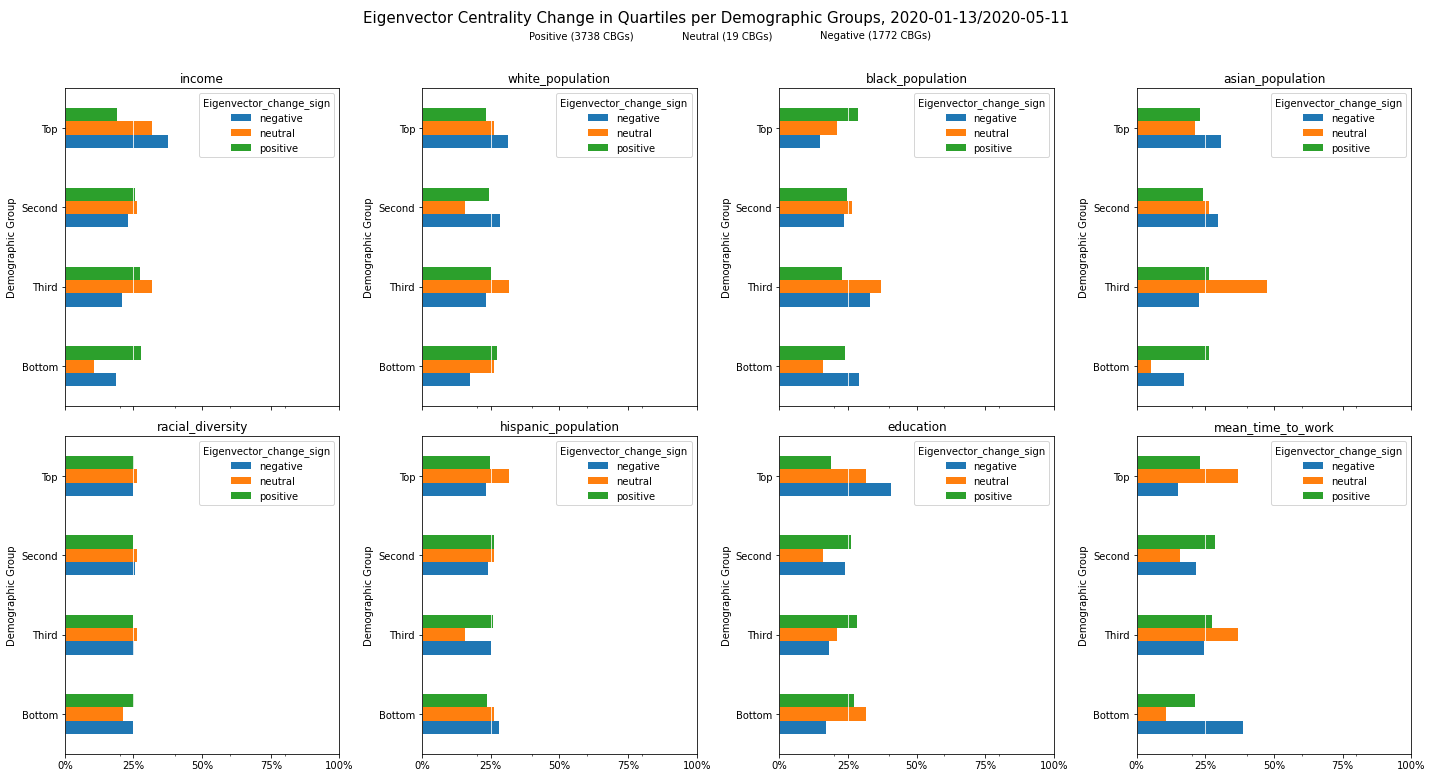

In [31]:
for metric_name, df in qdfs:
    df = df.dropna()
    for mode in ['index', 'columns']:
        plot_change_in_metrics_by_demo_groups(df, 
                                              metric_name, 
                                              'change_sign', 
                                              t1, 
                                              t2, 
                                              normalize=mode)